The dataset consists of proeotmics from 3 bones

1. skull (calvaria)
2. vertebra
3. pelvis

for 20 human samples

total 60 measurements.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random 

import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import anndata as ann

sc.settings.set_figure_params(dpi=100)


from utils import (
                    get_genes_per_group,                
                    filter_proteins_per_group, 
                    normalise,
                    impute_knn,
                    impute_knn_nan,
                    impute_min_value,
                    impute_min_value_nan,
                  )

from gprofiler import GProfiler
from gprofiler_plotting import plot_enrich, plot_gene_enrichment
from bioinfokit import analys, visuz
from upsetplot import plot, from_contents


In [3]:
samples_info = pd.DataFrame()
samples_info["sample num"] = [1, 2, 3, 4, 5, 6, 7, 8, 9,
                             16, 15, 17, 18, 10, 11, 12, 13, 20, 19, 14,
                             ]
samples_info["PMI (h)"] = [36, 36, 18, 36, 26, 28, 17, 27, 29,
                           300, 180, 217, 134, 325, 280, 255, 142, 220, 258, 466,
                          ]
samples_info["Cause of death"] = [
    "Asphyxiaton (Hanging/suicide)",
    "Dissection of aorta (Traffic accident)",
    "Asphyxiaton (possible anaphylactic shock)",
    "Hemorrhagic shock (Suicide)",
    "Hemorrhagic shock (complication during central venous cathederization)",
    "Polytrauma (Accident)",
    "Myocardial infarction",
    "Head shot (Suicide) possible M.Parkinson",
    "Hanging (suicide)",
    "Acute heart failure",
    "Hypothermia",
    "Acute heart failure",
    "Intoxication",
    "Pneumonia",
    "Pulmonary thromboembolism",
    "Bypass-Thrombosis",
    "Pulmonary thromboembolism",
    "Intracerebral bleeding",
    "Traumatic brain injury ",
    "Acute myocardial infarction",
]
samples_info["Cause of death"] = samples_info["Cause of death"].astype(str)
samples_info["age (years)"] = [
    23, 56, 56, 86, 77, 70, 69, 92, 39,
    91, 95, 72, 25, 73, 54, 85, 75, 46, 63, 71,
]
samples_info["sex"] = ["male", "male", "male", "male", "female", "male", "male", "male", "female",
                       "female", "female", "male", "male", "female", "male", "male", "male", "female", "male", "male"
                      ]

samples_info = samples_info.sort_values(by=['sample num'])

age_group = np.array([])
young_age = "21-40"
middle_age = "41-60"
upper_middle_age = "61-80"
old_age = "81+"
for a in samples_info["age (years)"]:
    if a <= 40:
        age_group = np.append(age_group, young_age)
    elif a <= 60:
        age_group = np.append(age_group, middle_age)
    elif a <= 80:
        age_group = np.append(age_group, upper_middle_age)
    else:
        age_group = np.append(age_group, old_age)

samples_info["age_group"] = age_group
samples_info

,sample num,PMI (h),Cause of death,age (years),sex,age_group
0,1,36,Asphyxiaton (Hanging/suicide),23,male,21-40
1,2,36,Dissection of aorta (Traffic accident),56,male,41-60
2,3,18,Asphyxiaton (possible anaphylactic shock),56,male,41-60
3,4,36,Hemorrhagic shock (Suicide),86,male,81+
4,5,26,Hemorrhagic shock (complication during central...,77,female,61-80
5,6,28,Polytrauma (Accident),70,male,61-80
6,7,17,Myocardial infarction,69,male,61-80
7,8,27,Head shot (Suicide) possible M.Parkinson,92,male,81+
8,9,29,Hanging (suicide),39,female,21-40
13,10,325,Pneumonia,73,female,61-80


In [4]:
DATA_DIR = ""
FILE_NAME = ""
delimiter = "\t"

In [5]:
data = pd.read_csv(f"{DATA_DIR}/{FILE_NAME}", delimiter=delimiter)

In [7]:
gene_column="Genes"

In [ ]:
# dropping genes with nan values
data = data[~data[gene_column].isna()]
data = data.reset_index()
data = data.drop(columns=["index"])

In [9]:
# specifying columns of interest

columns_calvaria = [col for col in data.columns if 'Calvaria' in col]
columns_vertebra = [col for col in data.columns if 'Vertebra' in col]
columns_pelvis = [col for col in data.columns if 'Pelvis' in col]

COLUMNS = columns_calvaria + columns_vertebra + columns_pelvis

In [11]:
df = pd.DataFrame()
regions = np.array([])
n_proteins = np.array([])
for c in COLUMNS:
    n = len(data) - data[c].isna().sum()
    region = c.split("_")[0]
    if region == "Calvaria":
        region = "Skull"
    regions = np.append(regions, region)
    n_proteins = np.append(n_proteins, n)
df["region"] = regions
df["number of proteins"] = n_proteins
df.head()

,region,number of proteins
0,Skull,6407.0
1,Skull,6567.0
2,Skull,5995.0
3,Skull,3901.0
4,Skull,6702.0


In [12]:
sns.set_palette("colorblind")

In [13]:
region_to_color = {
    "Calvaria"  : "#e377c2",
    "Brain"     : "#1f77b4",
    "Femur"     : "#ff7f0e",
    "Humerus"   : "#279e68",
    "Meninges"  : "#d62728",
    "Pelvis"    : "#aa40fc",
    "Scapula"   : "#8c564b",
    "Vertebra"  : "#b5bd61",
}

In [14]:
_color_Pelvis = region_to_color["Pelvis"]
_color_Calvaria = region_to_color["Calvaria"]
_color_Vertebra = region_to_color["Vertebra"]

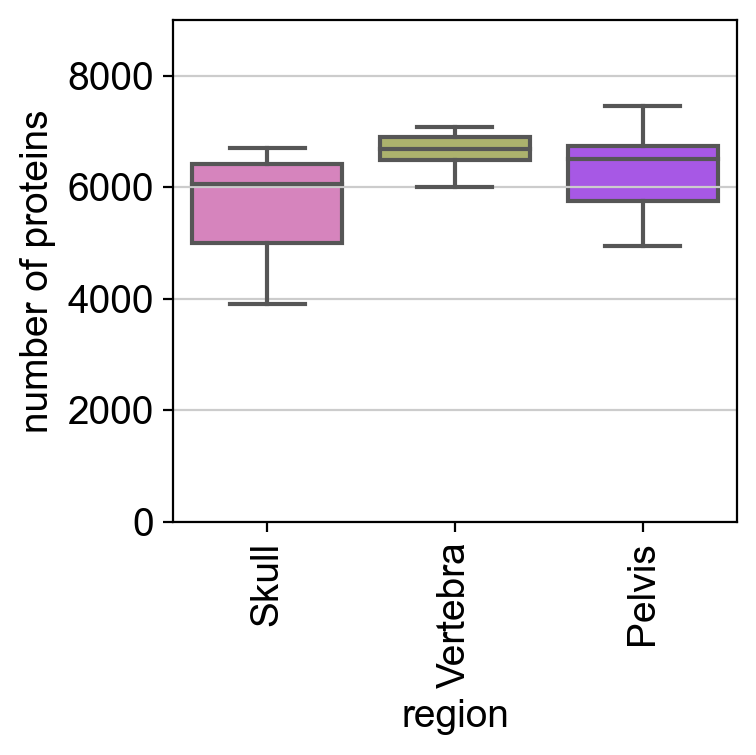

In [15]:
sns.boxplot(data=df,
                x="region",
                y="number of proteins",
                order=["Skull", "Vertebra", "Pelvis"],
                palette=[_color_Calvaria, _color_Vertebra, _color_Pelvis]
)
plt.xticks(rotation=90)
plt.ylim(0,9000)
plt.tight_layout()
plt.show()

#### Upsetplots

In [17]:
# unique gene - available in all samples

genes_calvaira = get_genes_per_group(data=data, 
                                       samples=columns_calvaria, 
                                       allow_na=True)
genes_pelvis = get_genes_per_group(data=data, 
                                           samples=columns_pelvis, 
                                           allow_na=True)
genes_vertebra = get_genes_per_group(data=data, 
                                           samples=columns_vertebra, 
                                           allow_na=True)

proteins_calvaira = get_genes_per_group(data=data, 
                                       samples=columns_calvaria, 
                                       allow_na=True,
                                    gene_column="Protein.Ids")
proteins_pelvis = get_genes_per_group(data=data, 
                                           samples=columns_pelvis, 
                                           allow_na=True,
                                          gene_column="Protein.Ids")
proteins_vertebra = get_genes_per_group(data=data, 
                                           samples=columns_vertebra, 
                                           allow_na=True,
                                        gene_column="Protein.Ids")

Before filtering:


/var/folders/v4/bvrmrlts5qb7pdsxz_52lkf1cjgg2l/T/ipykernel_67298/2237625781.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 2000x700 with 0 Axes>

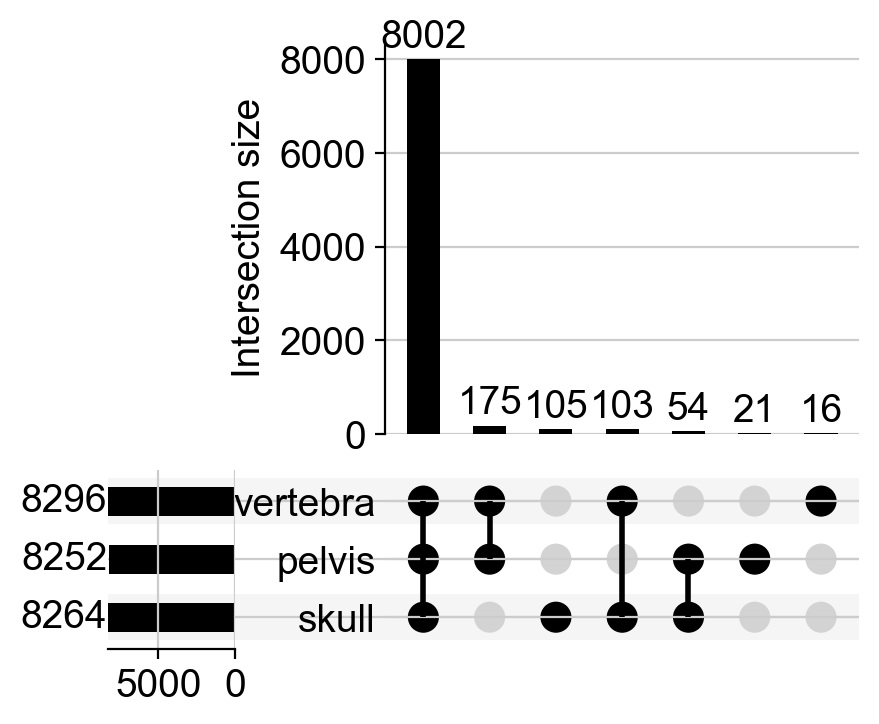

In [18]:
# plot upset plots - protein ids -- agreed on this
print('Before filtering:')
plt.figure(figsize=(20,7))
contents = {
            'skull': proteins_calvaira,    
            'pelvis': proteins_pelvis,  
            'vertebra': proteins_vertebra,
           }

plot(from_contents(contents), fig=plt.figure(figsize=(30,10)), 
     sort_categories_by=None, sort_by='cardinality', show_counts=True,
     orientation='horizontal'
    )
plt.tight_layout()
plt.show()



In [23]:
## unique calvaria 
unique_calvaria = list(set(genes_calvaira) - \
                             set(genes_pelvis) - \
                             set(genes_vertebra)
                            )


# vertebra and pelvis
veterbra_pelvis_genes = list(set(genes_vertebra) & set(genes_pelvis) - set(genes_calvaira))

# unique vertebra
unique_vertebra = list(set(genes_vertebra) - \
                             set(genes_pelvis) - \
                             set(genes_calvaira)
                            )

# unique pelvis
unique_pelvis = list(set(genes_pelvis) - \
                             set(genes_vertebra) - \
                             set(genes_calvaira)
                            )

In [25]:
SAVE_DIR="figures/gene_enrichment/unique/"

Unique calvaria genes not in other bones 
--------------------------------------------


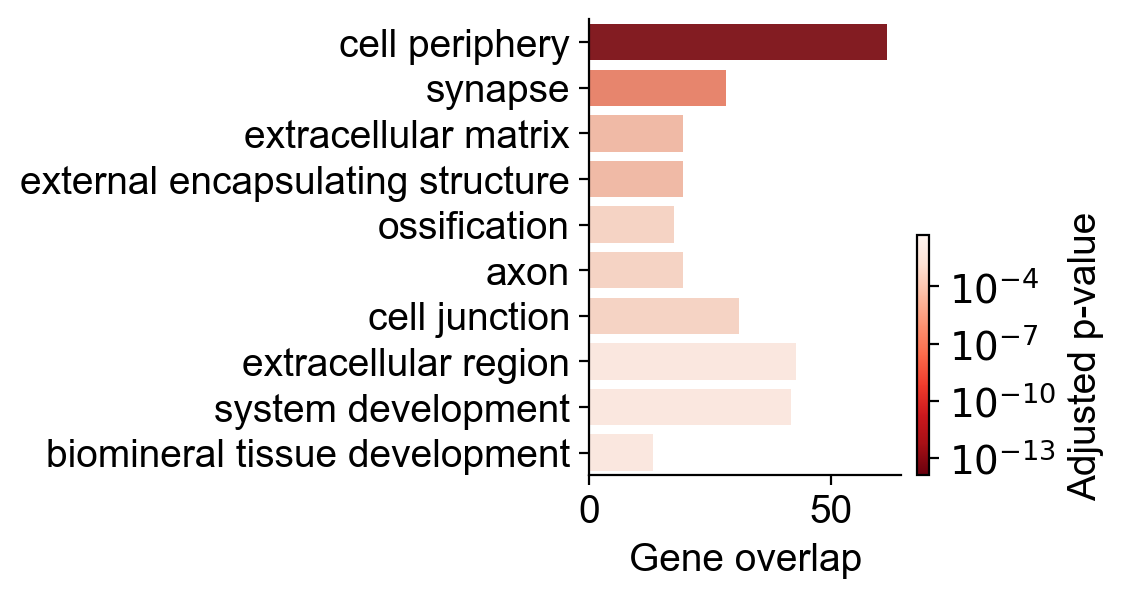

In [26]:
organism='hsapiens'
gp = GProfiler(return_dataframe=True, user_agent='g:GOSt')
print('Unique calvaria genes not in other bones ')
print('--------------------------------------------')
gene_enrichment = gp.profile(organism=organism,
                             query=unique_calvaria,
                             no_evidences=False,
                            )
# remove weird pathway
gene_enrichment = gene_enrichment[gene_enrichment["name"] != "cerebral cortex; neuropil[High]"]

# gene_enrichment.to_csv("results/final/before_filtering/gene_enrichment_unique_calvaria.csv")
gene_enrich_unique_results = gene_enrichment.set_index('native').sort_values('p_value').iloc[:,[2,5,7,10,1]]
plot_gene_enrichment(gene_enrich_unique_results, plot=True, 
                     n_terms=10,
                    )